In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
# I didn't revise this part as definition, because asset price setting can be changed anytime

corp = ['와이솔', '코웰패션', '코엔텍', '다나와', 'KOSDAQ']
symbol = ['122990', '033290', '029960', '119860', 'KQ11']
asset_num = len(corp)-1

df = pd.DataFrame()

for sym in symbol :
    df[sym] = fdr.DataReader(sym,'2012')['Close']
    
df.columns = corp
df_daily = df.iloc[:,:]

In [3]:
def daily_to_month(start, end, df_daily):
    
    s = pd.date_range(start, end, freq = 'MS')
    e = pd.date_range(start, end, freq = 'M')

    v = []

    for i, j in zip(s, e) :
        
        date = pd.date_range(i, j)
        
        df_date_range_value = df_daily.loc[date].dropna()
        
        value_result = df_date_range_value.iloc[[0]]
        
        v.append(value_result)

    df_month = pd.concat(v)
    
    return df_month

In [4]:
def price_to_return_rate(data) :
    
    df_2 = data
    
    df_pro = (df_2 - df_2.shift(1)).iloc[1:,:]
    df_pro2 = df_2.shift(1).iloc[1:,:]
    
    df_return = df_pro / df_pro2
    
    data = df_return.iloc[:,:]
    
    return data

In [5]:
# markowitz portfolio optimization

def optimizer_markowitz(value, asset_num, data) :
    
    def objective(weights):
        return 0.5 * np.sqrt(np.dot(weights.T, np.dot(r_cov, weights)))
    
    def constraint1(weights):
        return sum(weights)-1
    
    r_cov = data.cov()
    
    w0 = [(1 / asset_num) for i in range(asset_num)]
    w0 = np.array(w0)
    objective(w0)
    
    bound = [0,1]
    bnds = [bound for i in range(asset_num)]
    con1 = {'type':'eq','fun':constraint1}
    cons = [con1]
    cons
    
    sol = minimize(objective,w0,method='SLSQP',bounds = bnds, constraints = cons)
    
    return value * sol.x.round(3)

In [9]:
def main(df_daily, start, end):
    
    init = 1000000
    
    df_month = daily_to_month(start, end, df_daily)
    data = price_to_return_rate(df_month)
    
    # we will use 2 years' data as initial covariance matrix of markowitz model
    df_return = data.iloc[23: , : -1]
    
    data = data.iloc[ : , : -1]
    df_result = df_month.iloc[24: , : ]
    
    marko_init = optimizer_markowitz(init, asset_num, data.iloc[:23, :])
    
    result = []
    
    for i in range(len(df_return)) :

        if i == 0 :

            asset_divided = []
            for j in range(asset_num) :

                value = marko_init[j] * (1 + df_return.iloc[i,j])
                asset_divided.append(value)

            asset_sum = 0
            for k in asset_divided :
                asset_sum = asset_sum + k

            result.append(asset_sum)

        else :

            asset_divided = []
            for j in range(asset_num) :

                value = optimizer_markowitz(asset_sum, asset_num, data.iloc[:23+i,:])[j] * (1 + df_return.iloc[i, j])
                asset_divided.append(value)

            asset_sum = 0
            for k in asset_divided :
                asset_sum = asset_sum + k

            result.append(asset_sum)
            
    df_result['Portfolio'] = result
    graph_portfolio = df_result['Portfolio'] / df_result['Portfolio'].iloc[0]
    graph_benchmark = df_result.iloc[:, -2:-1] / df_result.iloc[:, -2:-1].iloc[0]

    plt.style.use('seaborn')
    plt.figure(figsize=(18,6))
    plt.title('Portfolio Simulation', fontsize = 20)
    plt.xlabel('Time', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.plot(graph_portfolio, c = 'deepskyblue', label = 'Portfolio')
    plt.plot(graph_benchmark, c = 'magenta', label = 'Benchmark')
    plt.legend(loc=0, fontsize = 15)
    
    return plt.show()

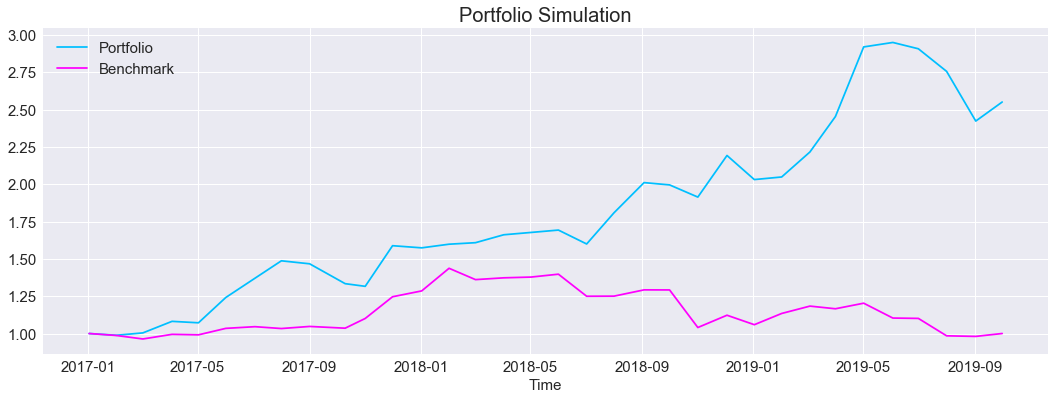

In [10]:
if __name__ == '__main__':
    main(df_daily, '2015-01-01', '2019-10-31')